In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# 1. Load Data

In [ ]:
df = pd.read_csv('Gabungann_final_no_year.csv')

# 2. Modifikasi Data

In [ ]:
# A. Perbaikan Format Timestamp
df['timestamp'] = '2025-' + df['timestamp'].str.replace('/', '-')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d-%H:%M:%S.%f', errors='coerce')

# C. Pastikan Port adalah Angka (Kadang Snort mencatat port sebagai service name)
df['src_port'] = pd.to_numeric(df['src_port'], errors='coerce').fillna(0)
df['dst_port'] = pd.to_numeric(df['dst_port'], errors='coerce').fillna(0)


--- Distribusi Data Serangan (Sebelum Split) ---
  Teknik Serangan (MITRE)  Jumlah Sampel Persentase
0                   T1499           3335     38.48%
1                   T1595           2197     25.35%
2                  Benign           1975     22.79%
3                   T1083            485       5.6%
4                   T1110            375      4.33%
5                   T1059            300      3.46%


/tmp/ipython-input-3852352297.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Jumlah Sampel', y='Teknik Serangan (MITRE)', data=jumlah_data, palette='viridis')


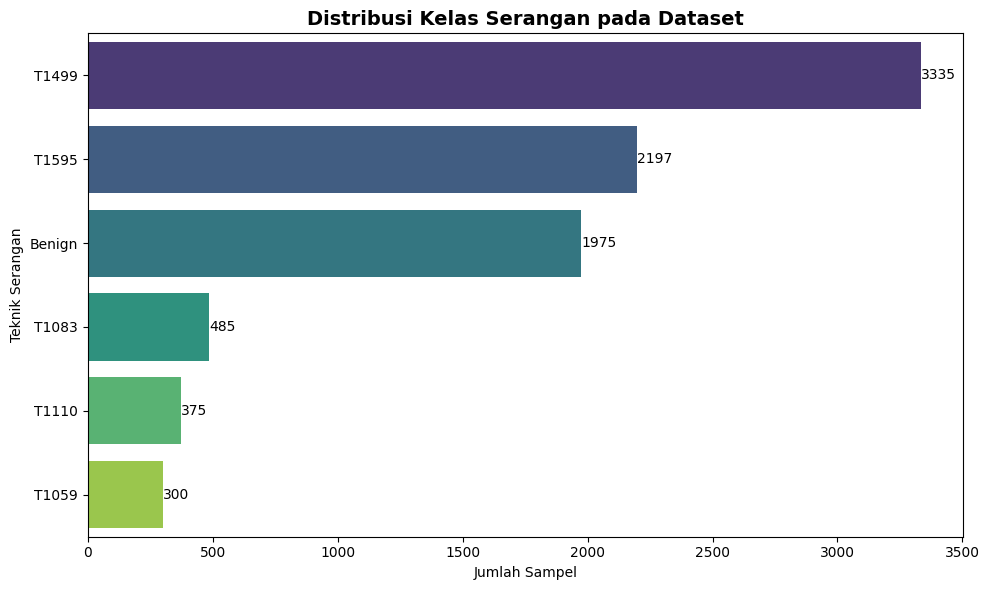

In [ ]:
# ==========================================
# CEK DISTRIBUSI DATA

# 1. Hitung jumlah data per label
jumlah_data = df['mitre'].value_counts().reset_index()
jumlah_data.columns = ['Teknik Serangan (MITRE)', 'Jumlah Sampel']

# 2. Hitung Persentase (Biar bagus buat Skripsi)
total_data = len(df)
jumlah_data['Persentase'] = (jumlah_data['Jumlah Sampel'] / total_data) * 100
jumlah_data['Persentase'] = jumlah_data['Persentase'].round(2).astype(str) + '%'

print("\n--- Distribusi Data Serangan (Sebelum Split) ---")
print(jumlah_data)

# ==========================================
# VISUALISASI (Opsional tapi Bagus)

plt.figure(figsize=(10, 6))
sns.barplot(x='Jumlah Sampel', y='Teknik Serangan (MITRE)', data=jumlah_data, palette='viridis')
plt.title('Distribusi Kelas Serangan pada Dataset', fontsize=14, weight='bold')
plt.xlabel('Jumlah Sampel')
plt.ylabel('Teknik Serangan')

for index, value in enumerate(jumlah_data['Jumlah Sampel']):
    plt.text(value, index, str(value), va='center')

plt.tight_layout()
plt.show()

# 3. Feature Engineering

In [ ]:
df = df.sort_values(by='timestamp')

# a. Selisih Waktu (Time Diff)
df['time_diff'] = df.groupby('src_ip')['timestamp'].diff().dt.total_seconds().fillna(0)

# b. Kepadatan Trafik (Packet Rate per detik)
df_indexed = df.set_index('timestamp')
df['pkt_rate_1s'] = (
    df
    .groupby(['src_ip', df['timestamp'].dt.floor('1s')])['src_port']
    .transform('count')
)


# c. Pola Port
df['same_dst_port'] = (df.groupby('src_ip')['dst_port'].diff() == 0).astype(int)
df['diff_src_port'] = (df.groupby('src_ip')['src_port'].diff() != 0).astype(int)

# 4. Preprocessing

In [ ]:
features_to_drop = ['timestamp', 'src_ip', 'dst_ip', 'mitre']

X = df.drop(columns=features_to_drop)

# Pastikan fitur penting masuk
X['src_port'] = df['src_port']
X['dst_port'] = df['dst_port']

# Encoding Protocol (TCP/UDP -> Angka)
le_proto = LabelEncoder()
X['protocol'] = le_proto.fit_transform(X['protocol'].astype(str))
X = X.fillna(0)

y = df['mitre'] # Label Target

# 5. Data Split

In [ ]:
# Tahap 1: Pisahkan data menjadi 80% Training dan 20% Sisanya (Temp)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Tahap 2: Pisahkan data "Sisanya" (20%) menjadi dua bagian sama rata
# 10% untuk Validation, 10% untuk Testing
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Jumlah Data Training   : {len(X_train)} baris (80%)")
print(f"Jumlah Data Validation : {len(X_val)} baris (10%)")
print(f"Jumlah Data Testing    : {len(X_test)} baris (10%)")

Jumlah Data Training   : 6933 baris (80%)
Jumlah Data Validation : 867 baris (10%)
Jumlah Data Testing    : 867 baris (10%)


# 6. Training Model

In [ ]:
# Latih Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Cek performa sementara di data Validation
print("--- Hasil Validasi (Try Out) ---")
print(rf_model.score(X_val, y_val))

--- Hasil Validasi (Try Out) ---
0.9919261822376009


# 7. Evaluasi

In [ ]:
# Prediksi
y_pred = rf_model.predict(X_test)

print("\n--- Classification Report (Snort) ---")
print(classification_report(y_test, y_pred, zero_division=0))

# Cek Feature Importance (Fitur apa yang paling berpengaruh?)
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print("\nFeature Importances:")
print(importances.sort_values(ascending=False))


--- Classification Report (Snort) ---
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99       198
       T1059       0.88      0.97      0.92        30
       T1083       0.98      0.92      0.95        48
       T1110       1.00      0.97      0.99        38
       T1499       1.00      1.00      1.00       333
       T1595       0.99      0.99      0.99       220

    accuracy                           0.99       867
   macro avg       0.97      0.97      0.97       867
weighted avg       0.99      0.99      0.99       867


Feature Importances:
pkt_rate_1s      0.313465
src_port         0.200404
protocol         0.177958
dst_port         0.117711
time_diff        0.103611
diff_src_port    0.067443
same_dst_port    0.019408
dtype: float64


In [ ]:
import joblib

# 1. Simpan model yang sudah dilatih
joblib.dump(rf_model, 'snort.pkl')

# 2. Simpan Label Encoder Protocol (karena ini yang ada di kode Anda)
joblib.dump(le_proto, 'proto_snort.pkl')

print("Model dan Encoder Berhasil Disimpan!")

Model dan Encoder Berhasil Disimpan!


# 8. Visualisasi

In [ ]:
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n--- Feature Importance ---")
print(feature_importances)


--- Feature Importance ---
         Feature  Importance
4    pkt_rate_1s    0.313465
1       src_port    0.200404
0       protocol    0.177958
2       dst_port    0.117711
3      time_diff    0.103611
6  diff_src_port    0.067443
5  same_dst_port    0.019408


In [ ]:
# ==========================================
# VISUALISASI UNTUK SKRIPSI
# ==========================================
# Set gaya visualisasi agar terlihat akademis/profesional
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# --- GRAFIK 1: FEATURE IMPORTANCE ---
# Grafik ini WAJIB ada untuk membuktikan hipotesis Anda tentang pola perilaku
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
# Gunakan palette warna yang kontras
barplot = sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')

plt.title('Feature Importance pada Model RF dengan log Snort', fontsize=14, pad=20, weight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Fitur', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Menambahkan nilai angka di ujung bar
for i, v in enumerate(feature_importances['Importance']):
    barplot.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('skripsi_feature_importance.png', dpi=300) # Simpan resolusi tinggi
plt.show()

# --- GRAFIK 2: CONFUSION MATRIX ---
# Menunjukkan performa detail per kelas
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar=False, annot_kws={"size": 14})

plt.title('Confusion Matrix Hasil Klasifikasi', fontsize=14, pad=20, weight='bold')
plt.xlabel('Label Prediksi', fontsize=12)
plt.ylabel('Label Sebenarnya', fontsize=12)
plt.tight_layout()
plt.savefig('skripsi_confusion_matrix.png', dpi=300)
plt.show()

# --- GRAFIK 3: DISTRIBUSI DATA TESTING ---
# Opsional: Untuk menunjukkan tantangan imbalanced data
plt.figure(figsize=(10, 6))
sns.countplot(y=y_test, order=y_test.value_counts().index, palette='pastel')
plt.title('Distribusi Teknik Serangan pada Data Uji', fontsize=14, pad=20, weight='bold')
plt.xlabel('Jumlah Sampel', fontsize=12)
plt.ylabel('Teknik Serangan (MITRE ATT&CK)', fontsize=12)
plt.tight_layout()
plt.savefig('skripsi_class_distribution.png', dpi=300)
plt.show()

# 9. Data Baru

In [ ]:
df_new = pd.read_csv('Testing_snort.csv')

df_new['timestamp'] = '2025-' + df_new['timestamp'].str.replace('/', '-')
df_new['timestamp'] = pd.to_datetime(
    df_new['timestamp'],
    format='%Y-%m-%d-%H:%M:%S.%f',
    errors='coerce'
)
df_new = df_new.sort_values(by='timestamp')


df_new['src_port'] = pd.to_numeric(df_new['src_port'], errors='coerce').fillna(0)
df_new['dst_port'] = pd.to_numeric(df_new['dst_port'], errors='coerce').fillna(0)


# Time difference
df_new['time_diff'] = (
    df_new.groupby('src_ip')['timestamp']
    .diff()
    .dt.total_seconds()
    .fillna(0)
)

# Packet rate per 1 detik
df_new_indexed = df_new.set_index('timestamp')
df_new['pkt_rate_1s'] = (
    df_new
    .groupby(['src_ip', df_new['timestamp'].dt.floor('1s')])['src_port']
    .transform('count')
)


# Pola port
df_new['same_dst_port'] = (
    df_new.groupby('src_ip')['dst_port']
    .diff()
    .fillna(1)
    .eq(0)
    .astype(int)
)

df_new['diff_src_port'] = (
    df_new.groupby('src_ip')['src_port']
    .diff()
    .fillna(1)
    .ne(0)
    .astype(int)
)

df_new['protocol'] = le_proto.transform(df_new['protocol'].astype(str))


features_to_drop = ['timestamp', 'src_ip', 'dst_ip', 'mitre', 'pkt_num', 'action', 'msg', 'label']

X_new = df_new.drop(columns=features_to_drop, errors='ignore')

# Pastikan urutan fitur SAMA dengan training
X_new = X_new[X_train.columns]

X_new = X_new.fillna(0)


df_new['predicted_mitre'] = rf_model.predict(X_new)

# Simpan hasil prediksi
df_new.to_csv('hasil_prediksi_data_baru.csv', index=False)

print("Prediksi selesai. File disimpan sebagai hasil_prediksi_data_baru.csv")


Prediksi selesai. File disimpan sebagai hasil_prediksi_data_baru.csv


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_true = df_new['mitre']
y_pred = df_new['predicted_mitre']

print("\n=== EVALUATION ON NEW TEST DATA ===")
print("Accuracy:", accuracy_score(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))



=== EVALUATION ON NEW TEST DATA ===
Accuracy: 0.9608791208791209

Classification Report:
              precision    recall  f1-score   support

      Benign       0.86      0.66      0.75        38
       T1059       0.97      0.82      0.89       175
       T1083       0.97      0.82      0.89       241
       T1110       0.99      1.00      1.00       150
       T1499       0.96      1.00      0.98      1585
       T1595       0.87      0.98      0.92        86

    accuracy                           0.96      2275
   macro avg       0.94      0.88      0.90      2275
weighted avg       0.96      0.96      0.96      2275



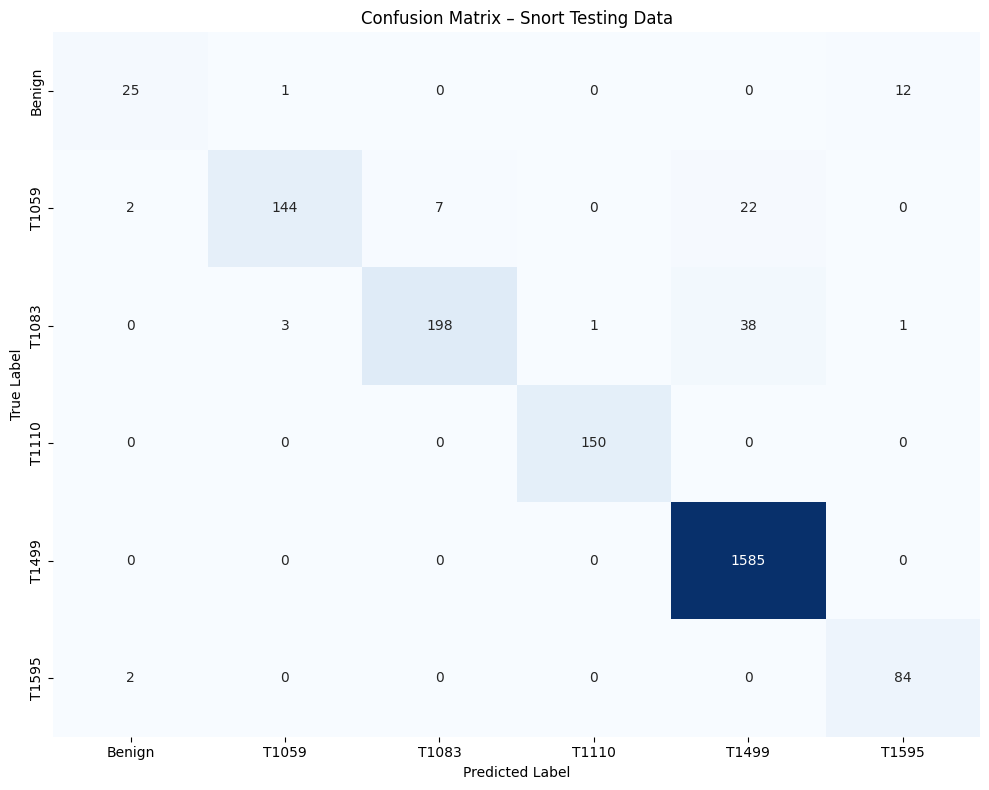

In [ ]:
cm = confusion_matrix(y_true, y_pred)
labels = sorted(y_true.unique())

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels,
    cbar=False
)

plt.title('Confusion Matrix – Snort Testing Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


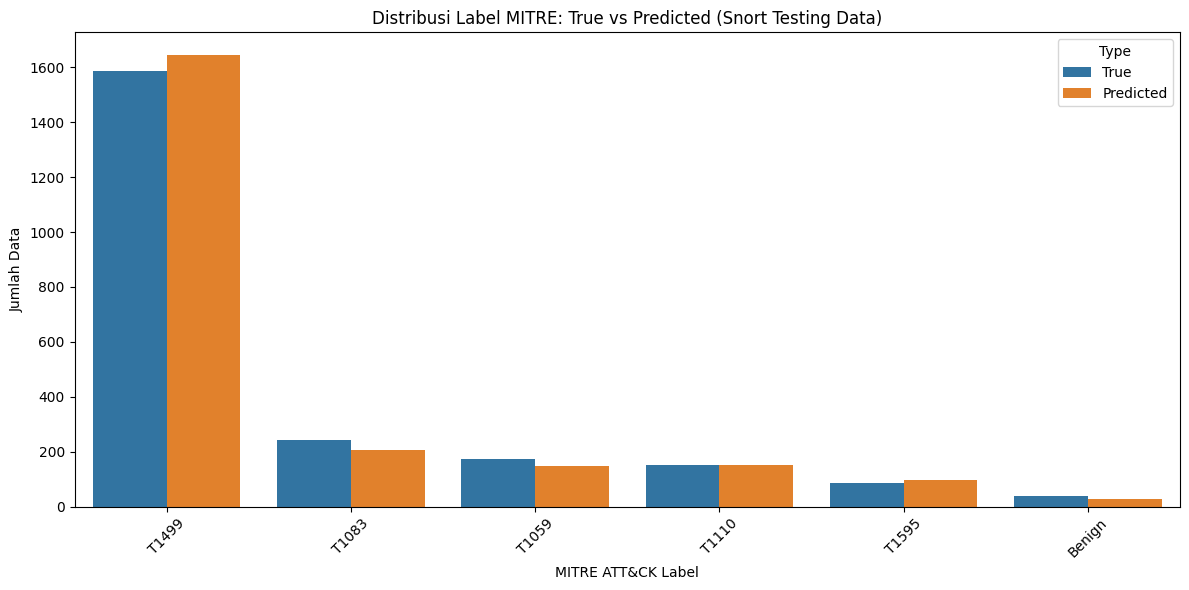

In [ ]:
df_true = pd.DataFrame({
    'MITRE': df_new['mitre'],
    'Type': 'True'
})

df_pred = pd.DataFrame({
    'MITRE': df_new['predicted_mitre'],
    'Type': 'Predicted'
})

df_plot = pd.concat([df_true, df_pred])

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_plot,
    x='MITRE',
    hue='Type',
    order=df_plot['MITRE'].value_counts().index
)

plt.title('Distribusi Label MITRE: True vs Predicted (Snort Testing Data)')
plt.xlabel('MITRE ATT&CK Label')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


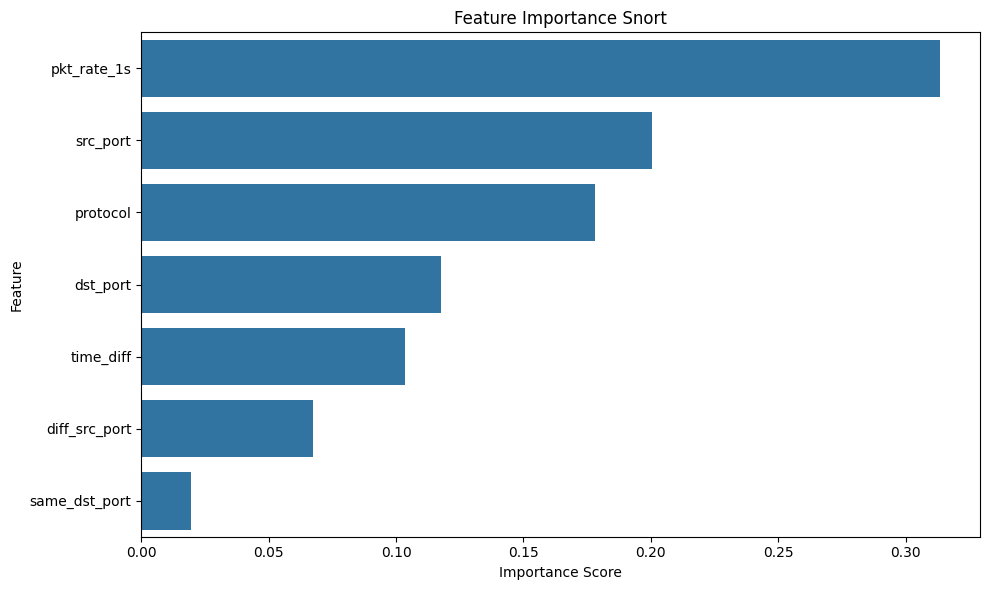

In [ ]:
importances = rf_model.feature_importances_

# DataFrame importance
df_importance = pd.DataFrame({
    'Feature': X_new.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Ambil Top-N
TOP_N = 15
df_top = df_importance.head(TOP_N)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_top,
    x='Importance',
    y='Feature'
)

plt.title('Feature Importance Snort')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [ ]:
# Hitung distribusi label asli
dist_true = df_new['mitre'].value_counts().reset_index()
dist_true.columns = ['MITRE_Technique', 'Jumlah']

# Hitung persentase
dist_true['Persentase (%)'] = (
    dist_true['Jumlah'] / dist_true['Jumlah'].sum() * 100
).round(2)

print("\n=== Distribusi Teknik Serangan (Label Asli) ===")
print(dist_true.to_string(index=False))



=== Distribusi Teknik Serangan (Label Asli) ===
MITRE_Technique  Jumlah  Persentase (%)
          T1499    1585           69.67
          T1083     241           10.59
          T1059     175            7.69
          T1110     150            6.59
          T1595      86            3.78
         Benign      38            1.67
